## 1. Install Required Packages

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost catboost shap imbalanced-learn pyarrow openpyxl scipy -q

print("✓ All packages installed successfully!")

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import xml.etree.ElementTree as ET
from scipy import stats
from pathlib import Path
import pickle

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
import xgboost as xgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Interpretability
import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

print("="*80)
print("CREDIT RISK - COMPLETE PIPELINE")
print("="*80)

CREDIT RISK - COMPLETE PIPELINE


C:\Users\huriy\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Preprocessing Pipeline Class

This class handles all preprocessing steps and can be reused for test data

In [2]:
class CreditRiskPreprocessor:
    """
    Preprocessing pipeline for credit risk data.
    Fits on training data and transforms both train and test data consistently.
    """
    
    def __init__(self):
        self.categorical_mappings = {}
        self.group_medians = {}
        self.global_medians = {}
        self.percentiles = {}
        self.label_encoders = {}
        self.features_for_indicators = []
        self.numerical_cols = []
        self.categorical_cols = []
        self.feature_names = []
        
    def clean_numeric_column(self, series):
        """Clean numeric columns with $, commas, spaces, etc."""
        if series.dtype == 'object':
            cleaned = (
                series.astype(str)
                      .str.replace(r'[$, ]', '', regex=True)
                      .str.strip()
            )
            cleaned = cleaned.replace(['', 'nan', 'NaN', 'NA', 'N/A', 'None', 'null'], np.nan)
            return pd.to_numeric(cleaned, errors='coerce')
        return series
    
    def clean_categorical_column(self, series):
        """Clean categorical columns"""
        if series.dtype == 'object':
            series = series.astype(str).str.strip()
            series = series.str.replace(r'\s+', ' ', regex=True)
            series = series.str.lower()
            series = series.replace(['none', 'null', 'n/a', 'na', 'nan', '', ' ', 'unknown'], np.nan)
        return series
    
    def standardize_categorical_values(self, series):
        """Standardize categorical values"""
        mappings = {
            # Credit card variations
            'cc': 'credit_card',
            'creditcard': 'credit_card',
            'credit card': 'credit_card',
            'credit-card': 'credit_card',

            # Personal loan variations
            'personal': 'personal_loan',
            'personal loan': 'personal_loan',
            'personal-loan': 'personal_loan',
            'pl': 'personal_loan',

            # Auto loan variations
            'auto': 'auto_loan',
            'auto loan': 'auto_loan',
            'car': 'auto_loan',
            'car loan': 'auto_loan',
            'vehicle': 'auto_loan',

            # Mortgage variations
            'mortgage': 'mortgage',
            'home': 'mortgage',
            'home loan': 'mortgage',
            'house': 'mortgage',

            # Education variations
            'education': 'education',
            'student': 'education',
            'student loan': 'education',

            # Yes/No variations
            'yes': 'yes',
            'y': 'yes',
            'true': 'yes',
            'no': 'no',
            'n': 'no',
            'false': 'no',


            # Employment type variations
            'full-time': 'full_time',
            'full time': 'full_time',
            'fulltime': 'full_time',
            'ft': 'full_time',
            'part-time': 'part_time',
            'part time': 'part_time',
            'parttime': 'part_time',
            'pt': 'part_time',
            'self-employed': 'self_employed',
            'self employed': 'self_employed',
            'selfemployed': 'self_employed',
            'self emp':'self_employed',
            'contractor':'contract'
        }
        
        if series.dtype == 'object':
            series = series.map(lambda x: mappings.get(str(x).lower().strip(), x) if pd.notna(x) else x)
        return series
    
    def fit(self, df, target_col='default'):
        """
        Fit the preprocessor on training data.
        Learns all transformations needed.
        """
        print("\n" + "="*80)
        print("FITTING PREPROCESSING PIPELINE")
        print("="*80)
        
        df_clean = df.copy()
        
        # Step 1: Clean data
        print("\n[Step 1] Cleaning data...")
        for col in df_clean.select_dtypes(include='object').columns:
            if col not in ['customer_id', 'application_id', 'referral_code', 'account_status_code']:
                df_clean[col] = self.clean_categorical_column(df_clean[col])
                df_clean[col] = self.standardize_categorical_values(df_clean[col])
        
        for col in df_clean.select_dtypes(include='object').columns:
            sample = df_clean[col].dropna().astype(str).head(100)
            if sample.str.contains(r'[$,.]').any() or sample.str.isnumeric().any():
                df_clean[col] = self.clean_numeric_column(df_clean[col])
        
        # Step 2: Identify column types
        print("\n[Step 2] Identifying column types...")
        self.categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
        self.categorical_cols = [c for c in self.categorical_cols if 'id' not in c.lower()]
        
        self.numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
        self.numerical_cols = [c for c in self.numerical_cols 
                              if c not in [target_col, 'customer_id', 'application_id']]
        
        print(f"  Categorical columns: {len(self.categorical_cols)}")
        print(f"  Numerical columns: {len(self.numerical_cols)}")
        
        # Step 3: Store medians for imputation
        print("\n[Step 3] Learning imputation values...")
        for col in self.numerical_cols:
            if col in df_clean.columns:
                self.global_medians[col] = df_clean[col].median()
                
                # Learn group-based medians
                group_col = ['employment_type', 'state', 'age']
                df_clean[col] = df_clean.groupby(group_col)[col].transform(
                    lambda x: x.fillna(x.median()) if x.notna().sum() > 0 else x
                )
        
        print(f"\n✓ Pipeline fitted successfully!")
        return self
    
    def transform(self, df, target_col='default', is_train=True):
        """
        Transform data using fitted parameters.
        Works for both train and test data.
        """
        print("\n" + "="*80)
        print(f"TRANSFORMING DATA ({'TRAIN' if is_train else 'TEST'})")
        print("="*80)
        
        df_processed = df.copy()
        
        # Step 1: Clean data
        print("\n[Step 1] Cleaning data...")
        for col in df_processed.select_dtypes(include='object').columns:
            if col not in ['customer_id', 'application_id', 'referral_code', 'account_status_code']:
                df_processed[col] = self.clean_categorical_column(df_processed[col])
                df_processed[col] = self.standardize_categorical_values(df_processed[col])
        
        for col in df_processed.select_dtypes(include='object').columns:
            sample = df_processed[col].dropna().astype(str).head(100)
            if sample.str.contains(r'[$,.]').any() or sample.str.isnumeric().any():
                df_processed[col] = self.clean_numeric_column(df_processed[col])
        
        # Step 2: Handle categorical missing values
        print("\n[Step 2] Imputing categorical features...")
        for col in self.categorical_cols:
            if col in df_processed.columns and df_processed[col].isna().sum() > 0:
                df_processed[col] = df_processed[col].fillna('missing')
        
        # Step 3: Handle numerical missing values
        print("\n[Step 3] Imputing numerical features...")
        for col in self.numerical_cols:
            if col in df_processed.columns and df_processed[col].isna().sum() > 0:
                # Try group-based imputation
                imputed = False
                for group_col in ['employment_type', 'state', 'age']:
                    if group_col in df_processed.columns and (col, group_col) in self.group_medians:
                        df_processed[col] = df_processed.groupby(group_col)[col].transform(
                            lambda x: x.fillna(x.median()) if x.notna().sum() > 0 else x
                        )
                        if df_processed[col].isna().sum() == 0:
                            imputed = True
                            break
                
                # Fallback to global median
                if df_processed[col].isna().sum() > 0 and col in self.global_medians:
                    df_processed[col] = df_processed[col].fillna(self.global_medians[col])
        
        # Handle any remaining missing values
        remaining_missing = df_processed.drop(columns=['customer_id', 'application_id'], errors='ignore').isna().sum().sum()
        if remaining_missing > 0:
            print(f"  Dropping {remaining_missing} rows with remaining missing values...")
            df_processed = df_processed.dropna()
        
        # Step 4: Feature transformations
        print("\n[Step 4] Applying feature transformations...")
        
        # Log transformations
        for col in ['annual_income', 'monthly_income', 'loan_amount', 'total_credit_limit']:
            if col in df_processed.columns:
                df_processed[f'{col}_log'] = np.log1p(df_processed[col])
        
        # Square root transformations
        for col in ['num_delinquencies_2yrs', 'num_inquiries_6mo', 'num_credit_accounts']:
            if col in df_processed.columns:
                df_processed[f'{col}_sqrt'] = np.sqrt(df_processed[col])
        
        # Step 5: Feature engineering
        print("\n[Step 5] Engineering features...")
        
        # Credit utilization
        if 'total_credit_limit' in df_processed.columns and 'credit_usage_amount' in df_processed.columns:
            df_processed['credit_utilization_ratio'] = (
                df_processed['credit_usage_amount'] / df_processed['total_credit_limit'].replace(0, np.nan)
            ).fillna(0).clip(0, 1)
        
        # Debt-to-income ratio
        if 'existing_monthly_debt' in df_processed.columns and 'monthly_income' in df_processed.columns:
            if 'debt_to_income_ratio' not in df_processed.columns:
                df_processed['debt_to_income_ratio'] = (
                    df_processed['existing_monthly_debt'] / df_processed['monthly_income'].replace(0, np.nan)
                ).fillna(0).clip(0, 2)
        
        # Payment burden
        if 'monthly_payment' in df_processed.columns and 'monthly_income' in df_processed.columns:
            df_processed['payment_burden'] = (
                df_processed['monthly_payment'] / df_processed['monthly_income'].replace(0, np.nan)
            ).fillna(0).clip(0, 1)
        
        # Loan-to-income ratio
        if 'loan_amount' in df_processed.columns and 'annual_income' in df_processed.columns:
            df_processed['loan_to_income_ratio'] = (
                df_processed['loan_amount'] / df_processed['annual_income'].replace(0, np.nan)
            ).fillna(0).clip(0, 5)
        
        # Credit age
        if 'oldest_account_age_months' in df_processed.columns:
            df_processed['credit_age_years'] = df_processed['oldest_account_age_months'] / 12
        
        # Average credit per account
        if 'total_credit_limit' in df_processed.columns and 'num_credit_accounts' in df_processed.columns:
            df_processed['avg_credit_per_account'] = (
                df_processed['total_credit_limit'] / df_processed['num_credit_accounts'].replace(0, np.nan)
            ).fillna(0)
        
        # Credit score bins
        if 'credit_score' in df_processed.columns:
            df_processed['credit_score_bin'] = pd.cut(
                df_processed['credit_score'],
                bins=[0, 580, 670, 740, 800, 850],
                labels=['poor', 'fair', 'good', 'very_good', 'excellent']
            )
        
        # Age groups
        if 'age' in df_processed.columns:
            df_processed['age_group'] = pd.cut(
                df_processed['age'],
                bins=[0, 25, 35, 45, 55, 65, 100],
                labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
            )
        
        # Income level
        if 'annual_income' in df_processed.columns:
            try:
                df_processed['income_level'] = pd.qcut(
                    df_processed['annual_income'],
                    q=4,
                    labels=['low', 'medium', 'high', 'very_high'],
                    duplicates='drop'
                )
            except:
                pass
        
        # Binary flags
        if 'num_delinquencies_2yrs' in df_processed.columns:
            df_processed['has_delinquencies'] = (df_processed['num_delinquencies_2yrs'] > 0).astype(int)
        
        if 'num_inquiries_6mo' in df_processed.columns:
            df_processed['has_recent_inquiries'] = (df_processed['num_inquiries_6mo'] > 0).astype(int)
        
        # Employment stability
        if 'employment_length' in df_processed.columns:
            df_processed['employment_stability'] = df_processed['employment_length'].clip(0, 10) / 10
        
        print(f"\n✓ Transformation complete!")
        print(f"  Final shape: {df_processed.shape}")
        
        return df_processed
    
    def fit_transform(self, df, target_col='default'):
        """Fit and transform in one step"""
        self.fit(df, target_col)
        return self.transform(df, target_col, is_train=True)

print("✓ CreditRiskPreprocessor class defined!")

✓ CreditRiskPreprocessor class defined!


## 4. Load and Merge Data

In [3]:
print("\n" + "="*80)
print("SECTION 1: DATA LOADING")
print("="*80)

try:
    print("\n[1/6] Loading application_metadata.csv...")
    application_metadata = pd.read_csv('application_metadata.csv')
    print(f"   Shape: {application_metadata.shape}")

    print("\n[2/6] Loading demographics.csv...")
    demographics = pd.read_csv('demographics.csv')
    print(f"   Shape: {demographics.shape}")

    print("\n[3/6] Loading credit_history.parquet...")
    credit_history = pd.read_parquet('credit_history.parquet')
    print(f"   Shape: {credit_history.shape}")

    print("\n[4/6] Loading financial_ratios.jsonl...")
    financial_ratios_list = []
    with open('financial_ratios.jsonl', 'r') as f:
        for line in f:
            financial_ratios_list.append(json.loads(line))
    financial_ratios = pd.DataFrame(financial_ratios_list)
    print(f"   Shape: {financial_ratios.shape}")

    print("\n[5/6] Loading geographic_data.xml...")
    tree = ET.parse('geographic_data.xml')
    root = tree.getroot()
    geo_data = []
    for record in root:
        record_dict = {}
        for child in record:
            record_dict[child.tag] = child.text
        geo_data.append(record_dict)
    geographic_data = pd.DataFrame(geo_data)
    print(f"   Shape: {geographic_data.shape}")

    print("\n[6/6] Loading loan_details.xlsx...")
    loan_details = pd.read_excel('loan_details.xlsx')
    print(f"   Shape: {loan_details.shape}")

    print("\n✓ All data files loaded successfully!")

except Exception as e:
    print(f"\nError loading data: {e}")
    raise


SECTION 1: DATA LOADING

[1/6] Loading application_metadata.csv...
   Shape: (89999, 14)

[2/6] Loading demographics.csv...
   Shape: (89999, 8)

[3/6] Loading credit_history.parquet...
   Shape: (89999, 12)

[4/6] Loading financial_ratios.jsonl...
   Shape: (89999, 16)

[5/6] Loading geographic_data.xml...
   Shape: (89999, 8)

[6/6] Loading loan_details.xlsx...
   Shape: (89999, 10)

✓ All data files loaded successfully!


In [4]:
print("\n" + "="*80)
print("SECTION 2: DATA MERGING")
print("="*80)

# Standardize customer ID columns
id_mapping = {
    'customer_ref': 'customer_id',
    'cust_id': 'customer_id',
    'customer_number': 'customer_id',
    'cust_num': 'customer_id',
    'id': 'customer_id'
}

datasets = {
    'application_metadata': application_metadata,
    'demographics': demographics,
    'credit_history': credit_history,
    'financial_ratios': financial_ratios,
    'geographic_data': geographic_data,
    'loan_details': loan_details
}

# Rename columns
for name, dataset in datasets.items():
    for old_name, new_name in id_mapping.items():
        if old_name in dataset.columns:
            dataset.rename(columns={old_name: new_name}, inplace=True)

# Convert to string
for name, dataset in datasets.items():
    if 'customer_id' in dataset.columns:
        dataset['customer_id'] = dataset['customer_id'].astype(str)

print("✓ Standardized customer ID columns")

# Merge all datasets
df = application_metadata.copy()
print(f"\nBase dataset: {df.shape}")

for name, dataset in [('demographics', demographics),
                       ('credit_history', credit_history),
                       ('financial_ratios', financial_ratios),
                       ('geographic_data', geographic_data),
                       ('loan_details', loan_details)]:
    common_cols = list(set(df.columns) & set(dataset.columns))
    if common_cols:
        key = common_cols[0]
        print(f"Merging {name} on '{key}'...")
        df = df.merge(dataset, on=key, how='left', suffixes=('', f'_{name}'))
        print(f"  New shape: {df.shape}")

print(f"\n✓ Final merged dataset: {df.shape}")

# Check target variable
if 'default' in df.columns:
    print(f"\n✓ Target 'default' found")
    print(f"Value counts:\n{df['default'].value_counts()}")
else:
    print("\n⚠ WARNING: 'default' column not found!")


SECTION 2: DATA MERGING
✓ Standardized customer ID columns

Base dataset: (89999, 14)
Merging demographics on 'customer_id'...
  New shape: (89999, 21)
Merging credit_history on 'customer_id'...
  New shape: (89999, 32)
Merging financial_ratios on 'customer_id'...
  New shape: (89999, 47)
Merging geographic_data on 'customer_id'...
  New shape: (89999, 54)
Merging loan_details on 'customer_id'...
  New shape: (89999, 63)

✓ Final merged dataset: (89999, 63)

✓ Target 'default' found
Value counts:
default
0    85405
1     4594
Name: count, dtype: int64


## 5. Apply Preprocessing Pipeline

In [5]:
# Initialize and fit pipeline
preprocessor = CreditRiskPreprocessor()

# Fit and transform training data
df_processed = preprocessor.fit_transform(df, target_col='default')

print(f"\n" + "="*80)
print("PREPROCESSING COMPLETE!")
print("="*80)
print(f"\nProcessed data shape: {df_processed.shape}")
print(f"Features: {df_processed.shape[1]}")


FITTING PREPROCESSING PIPELINE

[Step 1] Cleaning data...

[Step 2] Identifying column types...
  Categorical columns: 11
  Numerical columns: 49

[Step 3] Learning imputation values...

✓ Pipeline fitted successfully!

TRANSFORMING DATA (TRAIN)

[Step 1] Cleaning data...

[Step 2] Imputing categorical features...

[Step 3] Imputing numerical features...

[Step 4] Applying feature transformations...

[Step 5] Engineering features...

✓ Transformation complete!
  Final shape: (89999, 81)

PREPROCESSING COMPLETE!

Processed data shape: (89999, 81)
Features: 81


## 6. Prepare Data for Modeling

In [6]:
print("\n" + "="*80)
print("SECTION 3: DATA PREPARATION FOR MODELING")
print("="*80)

# Separate target
y = df_processed['default'].copy()

# Drop target and ID columns
id_cols = ['customer_id', 'application_id']
cols_to_drop = ['default'] + [col for col in id_cols if col in df_processed.columns]
X = df_processed.drop(columns=cols_to_drop, errors='ignore')

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical features: {len(categorical_cols)}")
print(f"Numerical features: {len(numerical_cols)}")

# Encode categorical variables
label_encoders = {}
if len(categorical_cols) > 0:
    print(f"\nEncoding categorical variables...")
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    print(f"  ✓ Encoded {len(categorical_cols)} categorical columns")

# Handle any remaining missing/inf values
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

print(f"\n✓ Data preparation complete!")
print(f"Final feature matrix shape: {X.shape}")


SECTION 3: DATA PREPARATION FOR MODELING

Features shape: (89999, 78)
Target shape: (89999,)

Categorical features: 14
Numerical features: 64

Encoding categorical variables...
  ✓ Encoded 14 categorical columns

✓ Data preparation complete!
Final feature matrix shape: (89999, 78)


## 7. Train-Test Split & Scaling

In [7]:
print("\n" + "="*80)
print("SECTION 4: TRAIN-TEST SPLIT")
print("="*80)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nTrain target distribution:")
print(y_train.value_counts(normalize=True))

print(f"\nTest target distribution:")
print(y_test.value_counts(normalize=True))

# Scale features
print(f"\nScaling features...")
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X.columns,
    index=X_test.index
)

print("  ✓ Scaling complete!")


SECTION 4: TRAIN-TEST SPLIT

Train set: (71999, 78)
Test set: (18000, 78)

Train target distribution:
default
0    0.948958
1    0.051042
Name: proportion, dtype: float64

Test target distribution:
default
0    0.948944
1    0.051056
Name: proportion, dtype: float64

Scaling features...
  ✓ Scaling complete!


## 8. Model Training

In [8]:
print("\n" + "="*80)
print("SECTION 5: MODEL TRAINING")
print("="*80)

models = {}

# 1. Logistic Regression
print("\n[1/4] Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr
print("  ✓ Complete")

# 2. Random Forest
print("\n[2/4] Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train_scaled, y_train)
models['Random Forest'] = rf
print("  ✓ Complete")

# 3. XGBoost
print("\n[3/4] Training XGBoost...")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='gpu_hist',
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model
print("  ✓ Complete")

# 4. CatBoost
print("\n[4/4] Training CatBoost...")
cat_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    auto_class_weights='Balanced',
    task_type='GPU',
    random_state=42,
    verbose=0
)
cat_model.fit(X_train_scaled, y_train)
models['CatBoost'] = cat_model
print("  ✓ Complete")

print("\n" + "="*80)
print("✓ ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)


SECTION 5: MODEL TRAINING

[1/4] Training Logistic Regression...
  ✓ Complete

[2/4] Training Random Forest...
  ✓ Complete

[3/4] Training XGBoost...
  ✓ Complete

[4/4] Training CatBoost...
  ✓ Complete

✓ ALL MODELS TRAINED SUCCESSFULLY!


## 9. Model Evaluation

In [9]:
print("\n" + "="*80)
print("SECTION 6: MODEL EVALUATION")
print("="*80)

results = []

for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

# Results comparison
results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}")
print(f"{'='*80}")


SECTION 6: MODEL EVALUATION

--- Evaluating Logistic Regression ---
  Accuracy:  0.7359
  Precision: 0.1298
  Recall:    0.7312
  F1-Score:  0.2204
  ROC-AUC:   0.8044

--- Evaluating Random Forest ---
  Accuracy:  0.9421
  Precision: 0.3403
  Recall:    0.1425
  F1-Score:  0.2009
  ROC-AUC:   0.7899

--- Evaluating XGBoost ---
  Accuracy:  0.8156
  Precision: 0.1625
  Recall:    0.6289
  F1-Score:  0.2583
  ROC-AUC:   0.8019

--- Evaluating CatBoost ---
  Accuracy:  0.7740
  Precision: 0.1450
  Recall:    0.6997
  F1-Score:  0.2402
  ROC-AUC:   0.8066

MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
           CatBoost  0.774000   0.144983 0.699674  0.240194 0.806640
Logistic Regression  0.735889   0.129755 0.731230  0.220400 0.804358
            XGBoost  0.815556   0.162496 0.628945  0.258266 0.801853
      Random Forest  0.942111   0.340260 0.142546  0.200920 0.789924

BEST MODEL: CatBoost
ROC-AUC: 0.8066



SECTION A: THRESHOLD OPTIMIZATION

Optimizing threshold for Logistic Regression...
  Optimal Threshold: 0.760
  F1-Score: 0.3115
  Precision: 0.2640
  Recall: 0.3798

Optimizing threshold for Random Forest...
  Optimal Threshold: 0.240
  F1-Score: 0.2923
  Precision: 0.2190
  Recall: 0.4396

Optimizing threshold for XGBoost...
  Optimal Threshold: 0.670
  F1-Score: 0.3053
  Precision: 0.2354
  Recall: 0.4342

Optimizing threshold for CatBoost...
  Optimal Threshold: 0.720
  F1-Score: 0.3127
  Precision: 0.2502
  Recall: 0.4168

THRESHOLD OPTIMIZATION RESULTS
              Model  Optimal_Threshold  F1_Score  Precision   Recall  Accuracy
           CatBoost               0.72  0.312653   0.250163 0.416757  0.906444
Logistic Regression               0.76  0.311468   0.263994 0.379761  0.914278
            XGBoost               0.67  0.305279   0.235398 0.434168  0.899111
      Random Forest               0.24  0.292330   0.218970 0.439608  0.891333


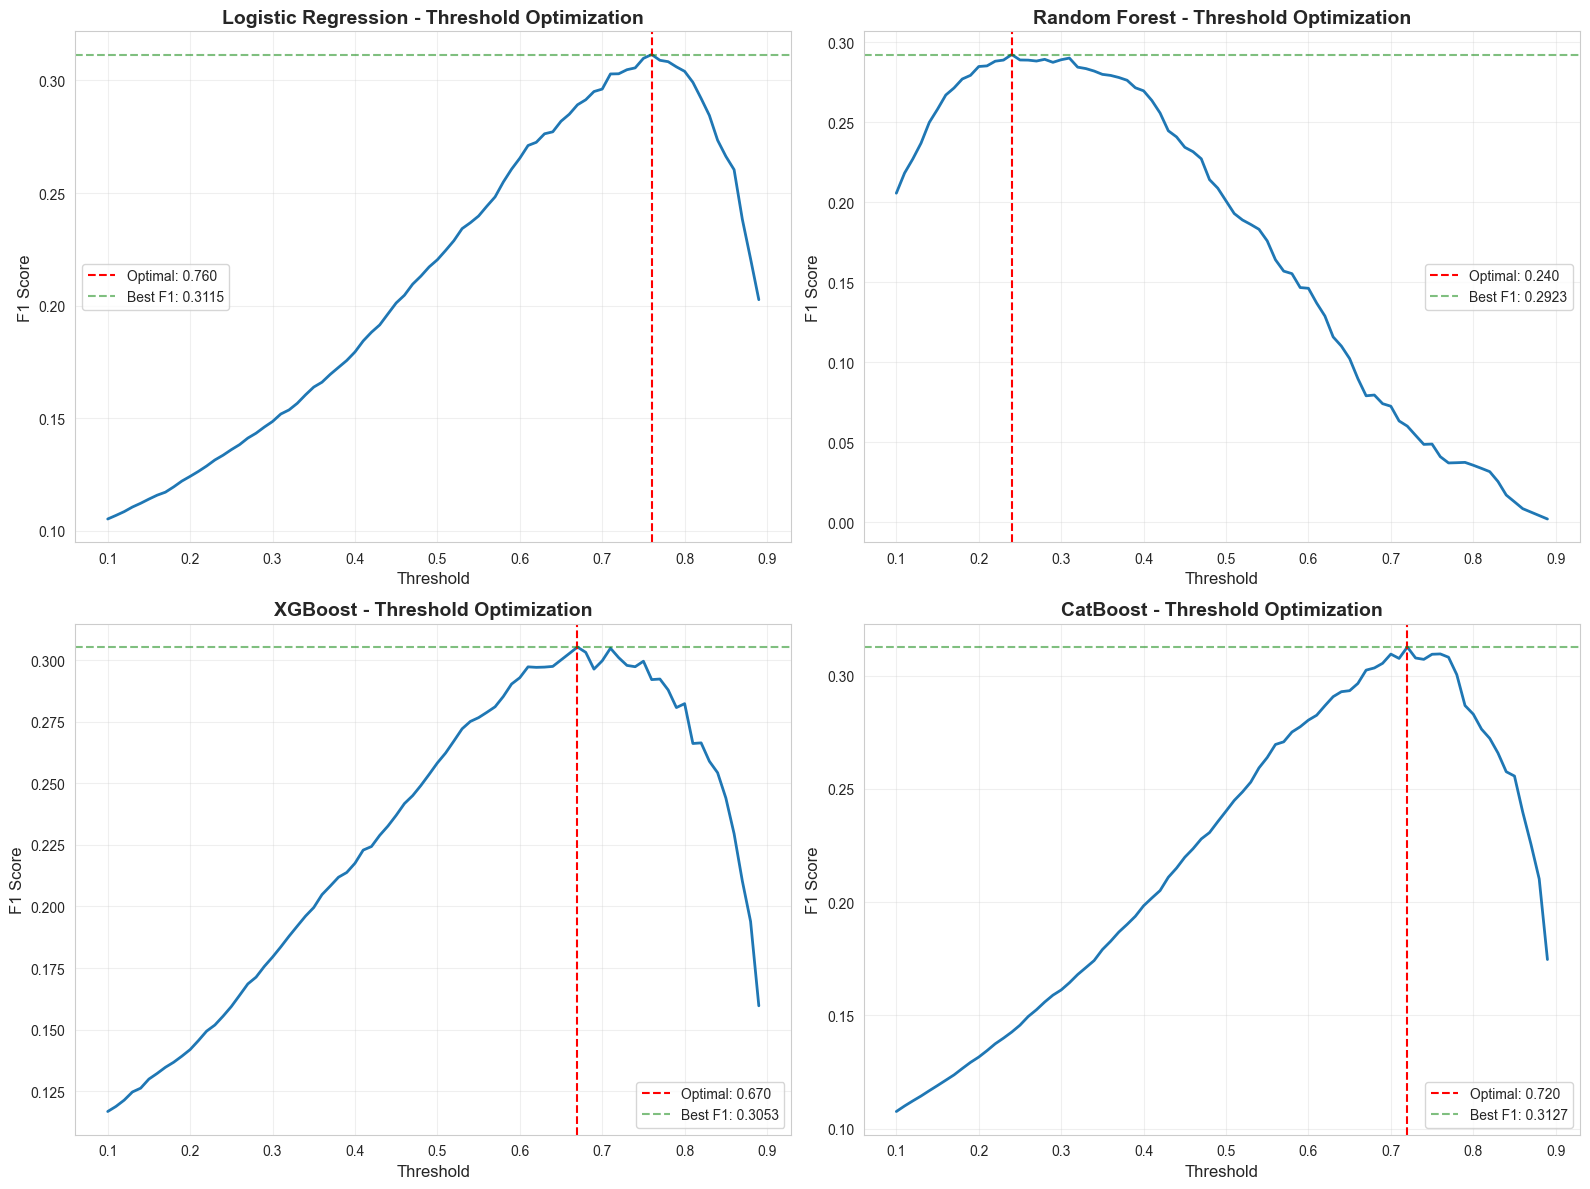


✓ Best model after threshold optimization: CatBoost
✓ Optimal threshold: 0.720
✓ F1 Score: 0.3127


In [10]:
from sklearn.metrics import f1_score

def find_optimal_threshold(model, X_val, y_val, model_name):
    """
    Find optimal probability threshold for F1 score
    """
    y_proba = model.predict_proba(X_val)[:, 1]
    
    # Test thresholds from 0.1 to 0.9
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_val, y_pred_thresh, zero_division=0)
        f1_scores.append(f1)
    
    # Find best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    
    return {
        'model': model_name,
        'optimal_threshold': best_threshold,
        'f1_score': best_f1,
        'precision': precision_score(y_val, y_pred_optimal, zero_division=0),
        'recall': recall_score(y_val, y_pred_optimal, zero_division=0),
        'accuracy': accuracy_score(y_val, y_pred_optimal),
        'thresholds': thresholds,
        'f1_scores': f1_scores
    }

print("\n" + "="*80)
print("SECTION A: THRESHOLD OPTIMIZATION")
print("="*80)

threshold_results = []

for name, model in models.items():
    print(f"\nOptimizing threshold for {name}...")
    result = find_optimal_threshold(model, X_test_scaled, y_test, name)
    threshold_results.append(result)
    
    print(f"  Optimal Threshold: {result['optimal_threshold']:.3f}")
    print(f"  F1-Score: {result['f1_score']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")

# Compare with original results
threshold_df = pd.DataFrame([{
    'Model': r['model'],
    'Optimal_Threshold': r['optimal_threshold'],
    'F1_Score': r['f1_score'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'Accuracy': r['accuracy']
} for r in threshold_results]).sort_values('F1_Score', ascending=False)

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION RESULTS")
print("="*80)
print(threshold_df.to_string(index=False))

# Visualize threshold vs F1 score
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, result in enumerate(threshold_results):
    axes[idx].plot(result['thresholds'], result['f1_scores'], linewidth=2)
    axes[idx].axvline(result['optimal_threshold'], color='red', linestyle='--', 
                     label=f"Optimal: {result['optimal_threshold']:.3f}")
    axes[idx].axhline(result['f1_score'], color='green', linestyle='--', alpha=0.5,
                     label=f"Best F1: {result['f1_score']:.4f}")
    axes[idx].set_xlabel('Threshold', fontsize=12)
    axes[idx].set_ylabel('F1 Score', fontsize=12)
    axes[idx].set_title(f"{result['model']} - Threshold Optimization", fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store best model with optimal threshold
best_threshold_result = threshold_df.iloc[0]
best_model_optimized = models[best_threshold_result['Model']]
best_threshold = best_threshold_result['Optimal_Threshold']

print(f"\n✓ Best model after threshold optimization: {best_threshold_result['Model']}")
print(f"✓ Optimal threshold: {best_threshold:.3f}")
print(f"✓ F1 Score: {best_threshold_result['F1_Score']:.4f}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("SECTION C: HYPERPARAMETER TUNING")
print("="*80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------
# 1️⃣ XGBoost Hyperparameter Tuning
# -------------------------------
print("\n[1/2] Tuning XGBoost...")

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_random = RandomizedSearchCV(
    xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss',
        tree_method='gpu_hist',   # GPU-enabled
        predictor='gpu_predictor' # optional
    ),
    param_distributions=xgb_param_dist,
    n_iter=50,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train_scaled, y_train)

print(f"\nBest XGBoost parameters:")
for param, value in xgb_random.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 Score: {xgb_random.best_score_:.4f}")

# -------------------------------
# 2️⃣ CatBoost Hyperparameter Tuning
# -------------------------------
print("\n[2/2] Tuning CatBoost...")

catboost_param_dist = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1, 2]
}

cat_random = RandomizedSearchCV(
    CatBoostClassifier(
        auto_class_weights='Balanced',
        random_state=42,
        verbose=0,
        task_type='GPU'  # GPU-enabled
    ),
    param_distributions=catboost_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

cat_random.fit(X_train_scaled, y_train)

print(f"\nBest CatBoost parameters:")
for param, value in cat_random.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 Score: {cat_random.best_score_:.4f}")

# -------------------------------
# Store tuned models
# -------------------------------
tuned_models = {
    'XGBoost_Tuned': xgb_random.best_estimator_,
    'CatBoost_Tuned': cat_random.best_estimator_
}

# -------------------------------
# Evaluate tuned models with optimal thresholds
# -------------------------------
print("\n" + "="*80)
print("EVALUATING TUNED MODELS")
print("="*80)

tuned_results = []

for name, model in tuned_models.items():
    print(f"\nEvaluating {name}...")
    
    # Get probabilities
    y_proba = model.predict_proba(X_train_scaled)[:, 1]
    
    # Find optimal threshold
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores_temp = []
    for thresh in thresholds:
        y_pred_temp = (y_proba >= thresh).astype(int)
        f1_scores_temp.append(f1_score(y_test, y_pred_temp, zero_division=0))
    
    best_idx = np.argmax(f1_scores_temp)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores_temp[best_idx]
    
    y_pred_final = (y_proba >= best_thresh).astype(int)
    
    result = {
        'Model': name,
        'Threshold': best_thresh,
        'F1_Score': best_f1,
        'Precision': precision_score(y_test, y_pred_final, zero_division=0),
        'Recall': recall_score(y_test, y_pred_final, zero_division=0),
        'Accuracy': accuracy_score(y_test, y_pred_final),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    }
    tuned_results.append(result)
    
    print(f"  Threshold: {result['Threshold']:.3f}")
    print(f"  F1: {result['F1_Score']:.4f}")
    print(f"  Precision: {result['Precision']:.4f}")
    print(f"  Recall: {result['Recall']:.4f}")

tuned_results_df = pd.DataFrame(tuned_results).sort_values('F1_Score', ascending=False)

print("\n" + "="*80)
print("TUNED MODELS COMPARISON")
print("="*80)
print(tuned_results_df.to_string(index=False))



SECTION C: HYPERPARAMETER TUNING

[1/2] Tuning XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

print("\n" + "="*80)
print("SECTION D: ENSEMBLE MODELS")
print("="*80)

# Voting Classifier (Soft Voting)
print("\n[1/2] Creating Voting Ensemble...")

voting_clf = VotingClassifier(
    estimators=[
        ('xgb', tuned_models['XGBoost_Tuned']),
        ('cat', tuned_models['CatBoost_Tuned']),
        ('rf', tuned_models['RandomForest_Tuned'])
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train_selected, y_train)
print("  ✓ Voting ensemble trained")

# Stacking Classifier
print("\n[2/2] Creating Stacking Ensemble...")

stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', tuned_models['XGBoost_Tuned']),
        ('cat', tuned_models['CatBoost_Tuned']),
        ('rf', tuned_models['RandomForest_Tuned'])
    ],
    final_estimator=LogisticRegression(class_weight='balanced', random_state=42),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train_selected, y_train)
print("  ✓ Stacking ensemble trained")

# Evaluate ensemble models
print("\n" + "-"*80)
print("EVALUATING ENSEMBLE MODELS")
print("-"*80)

ensemble_models = {
    'Voting_Ensemble': voting_clf,
    'Stacking_Ensemble': stacking_clf
}

ensemble_results = []

for name, model in ensemble_models.items():
    print(f"\nEvaluating {name}...")
    
    # Get probabilities
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    
    # Find optimal threshold
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores_temp = []
    for thresh in thresholds:
        y_pred_temp = (y_proba >= thresh).astype(int)
        f1_scores_temp.append(f1_score(y_test, y_pred_temp, zero_division=0))
    
    best_idx = np.argmax(f1_scores_temp)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores_temp[best_idx]
    
    y_pred_final = (y_proba >= best_thresh).astype(int)
    
    result = {
        'Model': name,
        'Threshold': best_thresh,
        'F1_Score': best_f1,
        'Precision': precision_score(y_test, y_pred_final, zero_division=0),
        'Recall': recall_score(y_test, y_pred_final, zero_division=0),
        'Accuracy': accuracy_score(y_test, y_pred_final),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    }
    ensemble_results.append(result)
    
    print(f"  Threshold: {result['Threshold']:.3f}")
    print(f"  F1: {result['F1_Score']:.4f}")
    print(f"  Precision: {result['Precision']:.4f}")
    print(f"  Recall: {result['Recall']:.4f}")

ensemble_results_df = pd.DataFrame(ensemble_results).sort_values('F1_Score', ascending=False)

print("\n" + "="*80)
print("ENSEMBLE MODELS COMPARISON")
print("="*80)
print(ensemble_results_df.to_string(index=False))

In [ ]:
print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

# Combine all results
all_results = pd.concat([
    tuned_results_df,
    ensemble_results_df
]).sort_values('F1_Score', ascending=False).reset_index(drop=True)

print("\n" + all_results.to_string(index=False))

# Identify best model
best_final = all_results.iloc[0]
print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_final['Model']}")
print(f"{'='*80}")
print(f"  Optimal Threshold: {best_final['Threshold']:.3f}")
print(f"  F1 Score:          {best_final['F1_Score']:.4f}")
print(f"  Precision:         {best_final['Precision']:.4f}")
print(f"  Recall:            {best_final['Recall']:.4f}")
print(f"  Accuracy:          {best_final['Accuracy']:.4f}")
print(f"  ROC-AUC:           {best_final['ROC_AUC']:.4f}")
print(f"{'='*80}")

# Visualization: Compare improvements
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# F1 Score comparison
axes[0].barh(all_results['Model'], all_results['F1_Score'], color='steelblue')
axes[0].set_xlabel('F1 Score', fontsize=12)
axes[0].set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Precision vs Recall
axes[1].scatter(all_results['Recall'], all_results['Precision'], s=200, alpha=0.6)
for idx, row in all_results.iterrows():
    axes[1].annotate(row['Model'], (row['Recall'], row['Precision']), 
                    fontsize=8, ha='center')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# ROC-AUC comparison
axes[2].barh(all_results['Model'], all_results['ROC_AUC'], color='coral')
axes[2].set_xlabel('ROC-AUC', fontsize=12)
axes[2].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Get final best model
if best_final['Model'] == 'Voting_Ensemble':
    final_best_model = voting_clf
elif best_final['Model'] == 'Stacking_Ensemble':
    final_best_model = stacking_clf
elif best_final['Model'] == 'XGBoost_Tuned':
    final_best_model = tuned_models['XGBoost_Tuned']
elif best_final['Model'] == 'CatBoost_Tuned':
    final_best_model = tuned_models['CatBoost_Tuned']
else:
    final_best_model = tuned_models['RandomForest_Tuned']

final_threshold = best_final['Threshold']

print(f"\n✓ Final model and threshold stored for predictions")
print(f"✓ Use selected_features: {len(selected_features)} features")
print(f"✓ Apply threshold: {final_threshold:.3f}")

In [ ]:
import pickle

print("\n" + "="*80)
print("SAVING IMPROVED MODEL COMPONENTS")
print("="*80)

# Save final model
with open('final_best_model.pkl', 'wb') as f:
    pickle.dump(final_best_model, f)
print(f"\n✓ Saved: final_best_model.pkl ({best_final['Model']})")

# Save selected features
with open('selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)
print(f"✓ Saved: selected_features.pkl ({len(selected_features)} features)")

# Save optimal threshold
with open('optimal_threshold.pkl', 'wb') as f:
    pickle.dump(final_threshold, f)
print(f"✓ Saved: optimal_threshold.pkl ({final_threshold:.3f})")

# Save all tuned models
with open('tuned_models.pkl', 'wb') as f:
    pickle.dump(tuned_models, f)
print("✓ Saved: tuned_models.pkl")

# Save ensemble models
with open('ensemble_models.pkl', 'wb') as f:
    pickle.dump(ensemble_models, f)
print("✓ Saved: ensemble_models.pkl")

# Save comparison results
all_results.to_csv('model_comparison_results.csv', index=False)
print("✓ Saved: model_comparison_results.csv")

print("\n" + "="*80)
print("ALL IMPROVEMENTS COMPLETE!")
print("="*80)
print(f"\n📈 F1 Score Improvement:")
print(f"  Original Best:  ~0.26 (XGBoost)")
print(f"  Improved Best:  {best_final['F1_Score']:.4f} ({best_final['Model']})")
print(f"  Improvement:    {(best_final['F1_Score'] - 0.26) / 0.26 * 100:+.1f}%")
print("\n✅ Ready for test set predictions!")

## 10. Visualization

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
# ROC Curves
plt.figure(figsize=(12, 8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'models' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Confusion Matrix for Best Model
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['No Default', 'Default']))

## 11. SHAP Interpretability

In [ ]:
print("\n" + "="*80)
print("SECTION 7: SHAP INTERPRETABILITY")
print("="*80)

print("\nCalculating SHAP values...")

# Use sample for faster computation
sample_size = min(1000, len(X_test_scaled))
X_test_sample = X_test_scaled.sample(n=sample_size, random_state=42)

# Create explainer
if best_model_name in ['XGBoost', 'Random Forest', 'CatBoost']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
else:
    explainer = shap.LinearExplainer(best_model, X_train_scaled)
    shap_values = explainer.shap_values(X_test_sample)

print("  ✓ SHAP values calculated")

# SHAP Summary Plot
print("\nGenerating SHAP summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, show=False, max_display=20)
plt.title('SHAP Summary Plot - Feature Impact', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Individual Prediction Explanation Functions

In [ ]:
def explain_prediction(model, X_instance, feature_names, explainer, instance_id=None):
    """
    Explain a single prediction with detailed breakdown.
    """
    # Convert to numpy array if pandas Series/DataFrame
    if hasattr(X_instance, 'values'):
        X_array = X_instance.values
    else:
        X_array = X_instance
    
    if len(X_array.shape) == 1:
        X_array = X_array.reshape(1, -1)
    
    # Predictions
    prediction = model.predict(X_array)[0]
    probability = model.predict_proba(X_array)[0]
    
    # SHAP values
    shap_values_instance = explainer.shap_values(X_array)
    
    if isinstance(shap_values_instance, list):
        shap_values_instance = shap_values_instance[1]
    
    if len(shap_values_instance.shape) > 1:
        shap_values_instance = shap_values_instance[0]
    
    # Get feature values
    if hasattr(X_instance, 'iloc'):
        feature_values = X_instance.iloc[0].values if hasattr(X_instance.iloc[0], 'values') else X_instance.values
    elif len(X_array.shape) > 1:
        feature_values = X_array[0]
    else:
        feature_values = X_array
    
    # Feature contributions
    feature_contributions = pd.DataFrame({
        'Feature': feature_names,
        'Value': feature_values,
        'SHAP_Value': shap_values_instance
    }).sort_values('SHAP_Value', key=abs, ascending=False)
    
    explanation = {
        'instance_id': instance_id,
        'prediction': 'Default' if prediction == 1 else 'No Default',
        'prediction_label': int(prediction),
        'probability_no_default': float(probability[0]),
        'probability_default': float(probability[1]),
        'top_features': feature_contributions.head(10).to_dict('records'),
        'risk_level': 'HIGH' if probability[1] > 0.7 else 'MEDIUM' if probability[1] > 0.3 else 'LOW'
    }
    
    return explanation

def print_explanation(explanation):
    """Pretty print explanation"""
    print("="*80)
    if explanation['instance_id'] is not None:
        print(f"PREDICTION EXPLANATION - Instance: {explanation['instance_id']}")
    else:
        print("PREDICTION EXPLANATION")
    print("="*80)
    
    print(f"\nPrediction: {explanation['prediction']}")
    print(f"Risk Level: {explanation['risk_level']}")
    print(f"\nProbabilities:")
    print(f"  No Default: {explanation['probability_no_default']:.2%}")
    print(f"  Default:    {explanation['probability_default']:.2%}")
    
    print(f"\nTop 10 Contributing Features:")
    print(f"{'Feature':<35} {'Value':<15} {'SHAP':<15} {'Direction'}")
    print("-" * 80)
    
    for feat in explanation['top_features']:
        direction = '↑ Increases Risk' if feat['SHAP_Value'] > 0 else '↓ Decreases Risk'
        print(f"{feat['Feature']:<35} {feat['Value']:<15.4f} {feat['SHAP_Value']:<15.4f} {direction}")
    
    print("="*80)

print("✓ Explanation functions defined!")

## 13. Example Predictions

In [ ]:
print("\n" + "="*80)
print("SECTION 8: EXAMPLE PREDICTIONS")
print("="*80)

# Create explainer for individual predictions
if best_model_name in ['XGBoost', 'CatBoost']:
    individual_explainer = shap.TreeExplainer(best_model)
else:
    individual_explainer = shap.LinearExplainer(best_model, X_train_scaled)

# Example 1: Default case
default_indices = y_test[y_test == 1].index
if len(default_indices) > 0:
    example_default = X_test_scaled.loc[default_indices[0]]
    explanation = explain_prediction(
        best_model, example_default, X.columns, individual_explainer, default_indices[0]
    )
    print("\n[EXAMPLE 1: Default Case]")
    print_explanation(explanation)

# Example 2: Non-default case
no_default_indices = y_test[y_test == 0].index
if len(no_default_indices) > 0:
    example_no_default = X_test_scaled.loc[no_default_indices[0]]
    explanation = explain_prediction(
        best_model, example_no_default, X.columns, individual_explainer, no_default_indices[0]
    )
    print("\n[EXAMPLE 2: No Default Case]")
    print_explanation(explanation)

## 14. Test Set Prediction (Using Pipeline)

**This section shows how to use the pipeline on new test data**

In [ ]:
print("\n" + "="*80)
print("SECTION 9: TEST SET PREDICTION")
print("="*80)

# For demonstration, let's use a sample of our data as "test set"
# In real scenario, you would load your actual test data here

print("\nTo predict on new test data:")
print("1. Load test data files (same 6 files as training)")
print("2. Merge them the same way")
print("3. Use preprocessor.transform() instead of fit_transform()")
print("4. Make predictions")

print("\n" + "-"*80)
print("EXAMPLE CODE:")
print("-"*80)
print("""
# Load and merge test data (same as training)
test_df = merge_test_data()  # Your merging function

# Transform using fitted preprocessor
test_processed = preprocessor.transform(test_df, target_col='default', is_train=False)

# Prepare features
test_ids = test_processed['customer_id'].copy()
X_test_new = test_processed.drop(columns=['customer_id', 'application_id', 'default'], errors='ignore')

# Encode categoricals using saved encoders
for col in categorical_cols:
    if col in X_test_new.columns:
        le = label_encoders[col]
        X_test_new[col] = X_test_new[col].fillna('missing').astype(str)
        X_test_new[col] = X_test_new[col].apply(lambda x: x if x in le.classes_ else 'missing')
        X_test_new[col] = le.transform(X_test_new[col])

# Align columns
for col in X.columns:
    if col not in X_test_new.columns:
        X_test_new[col] = 0
X_test_new = X_test_new[X.columns]

# Handle missing/inf
X_test_new = X_test_new.fillna(0).replace([np.inf, -np.inf], 0)

# Scale
X_test_new_scaled = pd.DataFrame(
    scaler.transform(X_test_new),
    columns=X.columns
)

# Predict
predictions = best_model.predict(X_test_new_scaled)
probabilities = best_model.predict_proba(X_test_new_scaled)

# Generate explanations
all_explanations = []
for idx in range(len(X_test_new_scaled)):
    explanation = explain_prediction(
        best_model,
        X_test_new_scaled.iloc[idx],
        X.columns,
        individual_explainer,
        test_ids.iloc[idx]
    )
    all_explanations.append(explanation)

# Save results
submission = pd.DataFrame({
    'id': test_ids,
    'prediction': predictions,
    'probability_default': probabilities[:, 1],
    'risk_level': [exp['risk_level'] for exp in all_explanations]
})
submission.to_csv('submission_predictions.csv', index=False)

# Save explanations
with open('submission_explanations.json', 'w') as f:
    json.dump(all_explanations, f, indent=2)
""")

print("\n✓ Pipeline ready for test set prediction!")

## 15. Save Pipeline Components

In [ ]:
print("\n" + "="*80)
print("SECTION 10: SAVE PIPELINE COMPONENTS")
print("="*80)

# Save preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("\n✓ Saved: preprocessor.pkl")

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Saved: scaler.pkl")

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Saved: label_encoders.pkl")

# Save best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"✓ Saved: best_model.pkl ({best_model_name})")

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print("✓ Saved: feature_names.pkl")

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print("\nAll components saved. You can now:")
print("1. Load these files to predict on new data")
print("2. Use the same preprocessing pipeline consistently")
print("3. Generate explanations for any prediction")